# ALBERT Sentiment Analysis Experiments on IMDb 50k Dataset using baseline model (and with PEFT -- LoRA, BitFit, Prompt Tuning)

In [1]:
"""We begin our process by installing packages such as pytorch, which is used extensively here, as well as HuggingFace's
transformers and datasets packages, which are used to run the ALBERT transformer model and load the IMDb 50k dataset, respectively. """

!pip install torch transformers datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
"""This step configures the credentials of the active user to seemlessly enable push and pull to and from the group's X-PERTS github repository"""

!git config --global credential.helper store

In [3]:
"""We next import the installed packages, namely the ALBERT model """

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

import time
from sklearn.metrics import classification_report, f1_score

In [4]:
""" We next instantiate (load) our IMDb 50k dataset"""

dataset_imdb = load_dataset("imdb")

full_imdb = concatenate_datasets([dataset_imdb["train"], dataset_imdb["test"]])

full_imdb_split = full_imdb.train_test_split(test_size=0.2, seed=42)

full_train = full_imdb_split["train"]
dataset = {"test": full_imdb_split["test"]}

print("Train size:", len(full_train))
print("Test size:", len(dataset["test"]))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train size: 40000
Test size: 10000


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "albert-base-v2"
num_labels = 2
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

tokenized_train = full_train.map(tokenize, batched=True)
tokenized_test = dataset["test"].map(tokenize, batched=True)

tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_test = tokenized_test.rename_column("label", "labels")

tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_test = tokenized_test.remove_columns(["text"])

tokenized_dataset = {"train": tokenized_train, "test": tokenized_test}

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
""" We print the head of each of the train/test sets to visualize our cleaned data"""

print("\nSample training examples:")
display(full_train[:5])

print("\nSample test examples:")
display(dataset["test"][:5])


Sample training examples:


{'text': ["Eugene O'Neill is acclaimed by some as America's leading playwright, but for things like The Iceman Cometh, Long Day's Journey Into Night, The Emperor Jones. Strange Interlude was a piece of experimentation he concocted where the characters on stage, look aside to the audience and say what they really are thinking and then resume conversation. It was a nine hour production with a dinner break on Broadway, so you can safely assume a lot has been sacrificed here.<br /><br />For the screen the voice over regarding the thoughts is used for all the characters. It probably is a technique better suited to the screen. Sir Laurence Olivier did very well with it in his version of Hamlet. But Bill Shakespeare gave Olivier a lot better story than O'Neill gave his players in this instance.<br /><br />Players like Clark Gable, Norma Shearer, Ralph Morgan, May Robson, etc. are a lot more animated in most of their films than they are in Strange Interlude. The story takes place over a 20 yea


Sample test examples:


{'text': ['I heard so much about this movie how it was a great slasher and one of those early 80\'s movies that die hard fans of most slasher movies just had to see. Well, I rented it and I have to say that although it kept my attention as far as the suspense goes for most slasher films such as "April Fools Day", "Friday 13th" and "Prom Night", this film could have been right up there with the above mentioned only it lacked true enthusiasm and potential from the characters as well as the on going story. Characters that I found were unfortunate to be in this movie was the weirdo guy with the frizzy hair that kept creeping around the dorm and of course leading up to his true climatic role during the end with he faces the killer. Another would be the dirty scruffy looking guy with the jean jacket, he could have played more roles in this movie that might have made the movie more interesting, instead, the movie played this guy as just another loser out there making unknown calls while he sl

In [8]:
""" We initialize our dataloader for each of the sets, fix their batch sizes
and randomize their order"""


from torch.utils.data import DataLoader
from transformers import default_data_collator

train_loader = DataLoader(tokenized_dataset["train"], batch_size=16, shuffle=True)
test_loader = DataLoader(tokenized_dataset["test"], batch_size=16, shuffle=False, collate_fn=default_data_collator)


Baseline Inference Performance - ALBERT on IMDb50k


Test Accuracy   : 0.4968
F1 Score (macro): 0.3319
F1 Score (weighted): 0.3298
Inference Time  : 21.48s

Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.66      4968
    Positive       0.00      0.00      0.00      5032

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


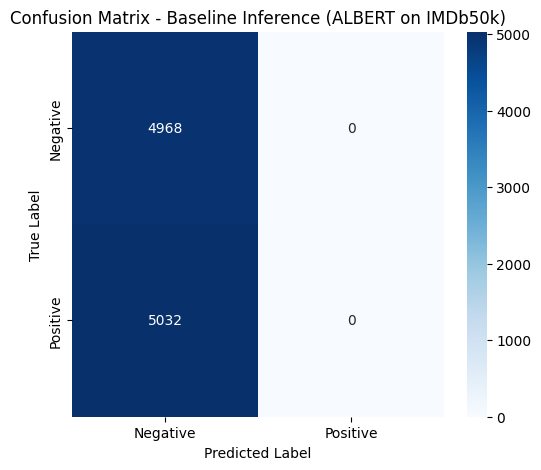

In [9]:
""" Baseline inference for binary sentiment analysis task run on ALBERT
without PEFT (i.e. without BitFit and/or LoRA)"""

import time
import torch
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

inference_start = time.time()

model.eval()
total_correct = 0
total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
f1_macro = f1_score(all_labels, all_preds, average="macro")
f1_weighted = f1_score(all_labels, all_preds, average="weighted")
inference_time = time.time() - inference_start

print(f'\nBaseline Inference Performance - ALBERT on IMDb50k\n')
print(f"\nTest Accuracy   : {accuracy:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"Inference Time  : {inference_time:.2f}s")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Baseline Inference (ALBERT on IMDb50k)")
plt.show()

# LORA

In [10]:
""" Install Parameter Efficient Finetuning Packages (e.g. LoRA and BitFit)"""

!pip install peft -q

In [11]:
""" Importing LoRA packages """

import gc
import torch
import time
import pandas as pd
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import classification_report, f1_score
from torch.utils.data import DataLoader

In [12]:
""" LoRA parameter setup """

learning_rates = [5e-5, 1e-4]
batch_sizes = [8, 16]
epochs = 6

In [14]:
""" Training on ALBERT model using LoRA and output dataset generation (saved as .csv)"""

results = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Running LoRA with LR={lr}, batch_size={batch_size}")

        # loading ALBERT model
        model_name = "albert-base-v2"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

        # LoRA param update config
        lora_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=16,
            lora_alpha=32,
            lora_dropout=0.1,
            bias="none",
            target_modules=["query", "key", "value"]
        )

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # instantiate dataloader
        data_collator = DataCollatorWithPadding(tokenizer)
        train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=batch_size, shuffle=True, collate_fn=data_collator)
        test_dataloader = DataLoader(tokenized_dataset["test"], batch_size=batch_size, shuffle=False, collate_fn=data_collator)

        # adam optimizer
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

        # begin training
        model.train()
        start_time = time.time()
        epoch_logs = []

        for epoch in range(1, epochs + 1):
            running_loss = 0.0
            correct = 0
            total = 0
            loop = tqdm(train_dataloader, leave=True, dynamic_ncols=True, desc=f"Epoch {epoch}/{epochs}")
            for step, batch in enumerate(loop):
                batch = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                    "labels": batch["labels"].to(device)
                }
                outputs = model(**batch)
                loss = outputs.loss
                preds = torch.argmax(outputs.logits, dim=1)
                correct += (preds == batch['labels']).sum().item()
                total += batch['labels'].size(0)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            avg_train_loss = running_loss / (step + 1)
            train_accuracy = correct / total

            # perform per epoch evaluation
            model.eval()
            val_running_loss = 0.0
            y_true, y_pred = [], []
            inference_start = time.time()
            with torch.no_grad():
                for batch in test_dataloader:
                    batch = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                    "labels": batch["labels"].to(device)
                    }
                    outputs = model(**batch)
                    preds = torch.argmax(outputs.logits, dim=1)
                    y_true.extend(batch["labels"].cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())
                    val_running_loss += outputs.loss.item()

            avg_val_loss = val_running_loss / len(test_dataloader)
            inference_time = time.time() - inference_start

            report = classification_report(y_true, y_pred, output_dict=True)
            val_accuracy = report["accuracy"]
            val_f1 = report["weighted avg"]["f1-score"]

            epoch_logs.append({
                "epoch": epoch,
                "lr": lr,
                "batch_size": batch_size,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy
            })

            if epoch == epochs:
                total_correct = sum(yt == yp for yt, yp in zip(y_true, y_pred))
                total_samples = len(y_true)
                accuracy = total_correct / total_samples
                f1_macro = f1_score(y_true, y_pred, average="macro")
                f1_weighted = f1_score(y_true, y_pred, average="weighted")

                print(f"\n[Final Epoch {epoch}] Inference Metrics:")
                print(f"Test Accuracy      : {accuracy:.4f}")
                print(f"F1 Score (macro)   : {f1_macro:.4f}")
                print(f"F1 Score (weighted): {f1_weighted:.4f}")
                print(f"Inference Time     : {inference_time:.2f} seconds")
                print("\nClassification Report: ALBERT w/ LoRA on IMDb50k\n")
                print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

            model.train()

        end_time = time.time()
        training_time = end_time - start_time

        # begin datalogging per lr/bs
        epoch_logs_df = pd.DataFrame(epoch_logs)
        epoch_logs_df.to_csv(f"imdb_albert_lora_epoch_logs_lr{lr}_bs{batch_size}.csv", index=False)

        # saver inference metrics per lr/bs
        metrics_summary_df = pd.DataFrame(report).transpose()
        metrics_summary_df.to_csv(f"imdb_albert_lora_inference_metrics_summary_lr{lr}_bs{batch_size}.csv", index=True)

        # save inference predictions for the final epoch
        predictions_df = pd.DataFrame({
            "y_true": y_true,
            "y_pred": y_pred
        })
        predictions_df.to_csv(f"imdb_albert_lora_inference_predictions_lr{lr}_bs{batch_size}.csv", index=False)

        # log memory usage
        max_memory = torch.cuda.max_memory_allocated() / (1024 ** 3) if torch.cuda.is_available() else 0

        # save model params and metrics
        results.append({
            "method": "LoRA",
            "learning_rate": lr,
            "batch_size": batch_size,
            "accuracy": val_accuracy,
            "f1": val_f1,
            "training_time": training_time,
            "inference_time": inference_time,
            "max_memory": max_memory
        })

        # empty cache to conserve compute
        del model, tokenizer, optimizer
        torch.cuda.empty_cache()
        gc.collect()

# ranked performance by val acc
results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

# save overall results
results_df = pd.DataFrame(results)
results_df.to_csv("imdb_albert_lora_results.csv", index=False)

# save best final config and metrics
final_summary_df = pd.DataFrame({
    "Method": ["LoRA"],
    "Best LR": [results[0]["learning_rate"]],
    "Best Batch Size": [results[0]["batch_size"]],
    "Accuracy": [results[0]["accuracy"]],
    "F1 Score": [results[0]["f1"]],
    "Training Time (s)": [results[0]["training_time"]],
    "Inference Time (s)": [results[0]["inference_time"]],
    "Max GPU Memory (GB)": [results[0]["max_memory"]]
})
final_summary_df.to_csv("imdb_albert_lora_final_comparison_lora.csv", index=False)

print("All LoRA Grid Search Results:")
for r in results:
    print(r)

print("\nBest LoRA Configuration:")
print(results[0])

Running LoRA with LR=5e-05, batch_size=8


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/6: 100%|██████████| 5000/5000 [04:01<00:00, 20.69it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/


[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.5032
F1 Score (macro)   : 0.3348
F1 Score (weighted): 0.3369
Inference Time     : 21.92 seconds

Classification Report: ALBERT w/ LoRA on IMDb50k

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      4968
    Positive       0.50      1.00      0.67      5032

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.34     10000

Running LoRA with LR=5e-05, batch_size=16


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/6: 100%|██████████| 2500/2500 [03:45<00:00, 11.07it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/


[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.8324
F1 Score (macro)   : 0.8323
F1 Score (weighted): 0.8324
Inference Time     : 21.28 seconds

Classification Report: ALBERT w/ LoRA on IMDb50k

              precision    recall  f1-score   support

    Negative       0.84      0.82      0.83      4968
    Positive       0.83      0.85      0.84      5032

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

Running LoRA with LR=0.0001, batch_size=8


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/6: 100%|██████████| 5000/5000 [04:05<00:00, 20.40it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/


[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.5032
F1 Score (macro)   : 0.3348
F1 Score (weighted): 0.3369
Inference Time     : 21.81 seconds

Classification Report: ALBERT w/ LoRA on IMDb50k

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      4968
    Positive       0.50      1.00      0.67      5032

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.34     10000

Running LoRA with LR=0.0001, batch_size=16


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/6: 100%|██████████| 2500/2500 [03:46<00:00, 11.06it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/


[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.5032
F1 Score (macro)   : 0.3348
F1 Score (weighted): 0.3369
Inference Time     : 21.19 seconds

Classification Report: ALBERT w/ LoRA on IMDb50k

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      4968
    Positive       0.50      1.00      0.67      5032

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.34     10000

All LoRA Grid Search Results:
{'method': 'LoRA', 'learning_rate': 5e-05, 'batch_size': 16, 'accuracy': 0.8324, 'f1': 0.8323609152738943, 'training_time': 1480.5105419158936, 'inference_time': 21.280505895614624, 'max_memory': 2.270575523376465}
{'method': 'LoRA', 'learning_rate': 5e-05, 'batch_size': 8, 'accuracy': 0.5032, 'f1': 0.3368949441192124, 'training_time': 1580.6496484279633, 'inference_time': 21.919774770736694, 'max_memory': 1.1930804252624512}
{'metho


Classification Report for Best Configuration:
     Unnamed: 0  precision    recall  f1-score     support
0             0   0.839802  0.818841  0.829189   4968.0000
1             1   0.825446  0.845787  0.835493   5032.0000
2      accuracy   0.832400  0.832400  0.832400      0.8324
3     macro avg   0.832624  0.832314  0.832341  10000.0000
4  weighted avg   0.832578  0.832400  0.832361  10000.0000

Inference Predictions for Best Configuration:
      y_true  y_pred
0          0       0
1          1       0
2          1       1
3          0       0
4          1       1
...      ...     ...
9995       1       1
9996       1       1
9997       1       1
9998       1       1
9999       1       0

[10000 rows x 2 columns]


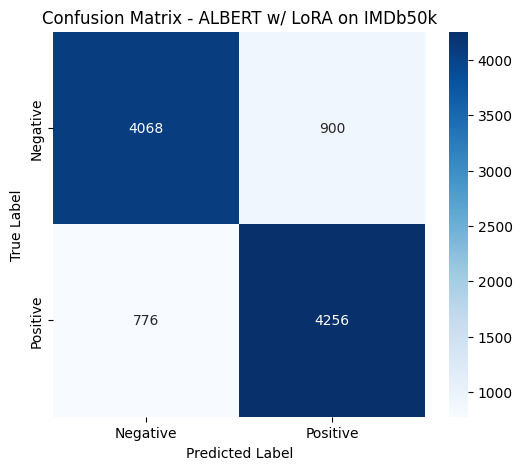

In [15]:
lora_best_lr = results[0]["learning_rate"]
lora_best_bs = results[0]["batch_size"]

# Construct filename
best_report_file = f"imdb_albert_lora_inference_metrics_summary_lr{lora_best_lr}_bs{lora_best_bs}.csv"

# Load the saved best report
best_report_df = pd.read_csv(best_report_file)
print("\nClassification Report for Best Configuration:")
print(best_report_df)


best_preds_df = pd.read_csv(f"imdb_albert_lora_inference_predictions_lr{lora_best_lr}_bs{lora_best_bs}.csv")
print("\nInference Predictions for Best Configuration:")
print(best_preds_df)

y_true = best_preds_df["y_true"]
y_pred = best_preds_df["y_pred"]


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ALBERT w/ LoRA on IMDb50k")
plt.show()

# BITFIT

In [16]:
""" Importing BitFit packages """

import gc
import torch
import time
import pandas as pd
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import classification_report, f1_score
from torch.utils.data import DataLoader

In [17]:
""" BitFit parameter setup """
learning_rates = [5e-5, 1e-4]
batch_sizes = [8, 16]
epochs = 6

In [19]:
""" Training on ALBERT model using BitFit and output dataset generation (saved as .csv)"""

results = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Running BitFit with LR={lr}, batch_size={batch_size}")

        # loading ALBERT model
        model_name = "albert-base-v2"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

        # BitFit param update config
        for name, param in model.named_parameters():
            if "bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # instantiate dataloader
        data_collator = DataCollatorWithPadding(tokenizer)
        train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=batch_size, shuffle=True, collate_fn=data_collator)
        test_dataloader = DataLoader(tokenized_dataset["test"], batch_size=batch_size, shuffle=False, collate_fn=data_collator)

        # adam optimizer
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

        # begin training
        model.train()
        start_time = time.time()
        epoch_logs = []

        for epoch in range(1, epochs + 1):
            running_loss = 0.0
            correct = 0
            total = 0
            loop = tqdm(train_dataloader, leave=True, dynamic_ncols=True, desc=f"Epoch {epoch}/{epochs}")
            for step, batch in enumerate(loop):
                batch = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                    "labels": batch["labels"].to(device)
                }
                outputs = model(**batch)
                loss = outputs.loss
                preds = torch.argmax(outputs.logits, dim=1)
                correct += (preds == batch['labels']).sum().item()
                total += batch['labels'].size(0)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            avg_train_loss = running_loss / (step + 1)
            train_accuracy = correct / total

            # perform per epoch evaluation
            model.eval()
            val_running_loss = 0.0
            y_true, y_pred = [], []
            inference_start = time.time()
            with torch.no_grad():
                for batch in test_dataloader:
                    batch = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                    "labels": batch["labels"].to(device)
                    }
                    outputs = model(**batch)
                    preds = torch.argmax(outputs.logits, dim=1)
                    y_true.extend(batch["labels"].cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())
                    val_running_loss += outputs.loss.item()

            avg_val_loss = val_running_loss / len(test_dataloader)

            inference_time = time.time() - inference_start

            report = classification_report(y_true, y_pred, output_dict=True)
            val_accuracy = report["accuracy"]
            val_f1 = report["weighted avg"]["f1-score"]

            epoch_logs.append({
                "epoch": epoch,
                "lr": lr,
                "batch_size": batch_size,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy
            })

            if epoch == epochs:
                total_correct = sum(yt == yp for yt, yp in zip(y_true, y_pred))
                total_samples = len(y_true)
                accuracy = total_correct / total_samples
                f1_macro = f1_score(y_true, y_pred, average="macro")
                f1_weighted = f1_score(y_true, y_pred, average="weighted")

                print(f"\n[Final Epoch {epoch}] Inference Metrics:")
                print(f"Test Accuracy      : {accuracy:.4f}")
                print(f"F1 Score (macro)   : {f1_macro:.4f}")
                print(f"F1 Score (weighted): {f1_weighted:.4f}")
                print(f"Inference Time     : {inference_time:.2f} seconds")
                print("\nClassification Report: ALBERT w/ BitFit on IMDb50k\n")
                print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

            model.train()

        end_time = time.time()
        training_time = end_time - start_time

        # begin datalogging per lr/bs
        epoch_logs_df = pd.DataFrame(epoch_logs)
        epoch_logs_df.to_csv(f"imdb_albert_bitfit_epoch_logs_lr{lr}_bs{batch_size}.csv", index=False)

        # saver inference metrics per lr/bs
        metrics_summary_df = pd.DataFrame(report).transpose()
        metrics_summary_df.to_csv(f"imdb_albert_bitfit_inference_metrics_summary_lr{lr}_bs{batch_size}.csv", index=True)

        # save inference predictions for the final epoch
        predictions_df = pd.DataFrame({
            "y_true": y_true,
            "y_pred": y_pred
        })
        predictions_df.to_csv(f"imdb_albert_bitfit_inference_predictions_lr{lr}_bs{batch_size}.csv", index=False)

        # log memory usage
        max_memory = torch.cuda.max_memory_allocated() / (1024 ** 3) if torch.cuda.is_available() else 0

        # save model params and metrics
        results.append({
            "method": "BitFit",
            "learning_rate": lr,
            "batch_size": batch_size,
            "accuracy": val_accuracy,
            "f1": val_f1,
            "training_time": training_time,
            "inference_time": inference_time,
            "max_memory": max_memory
        })

        # empty cache to conserve compute
        del model, tokenizer, optimizer
        torch.cuda.empty_cache()
        gc.collect()

# ranked performance by val acc
results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

# save overall results
results_df = pd.DataFrame(results)
results_df.to_csv("imdb_albert_bitfit_results.csv", index=False)

# save best final config and metrics
final_summary_df = pd.DataFrame({
    "Method": ["BitFit"],
    "Best LR": [results[0]["learning_rate"]],
    "Best Batch Size": [results[0]["batch_size"]],
    "Accuracy": [results[0]["accuracy"]],
    "F1 Score": [results[0]["f1"]],
    "Training Time (s)": [results[0]["training_time"]],
    "Inference Time (s)": [results[0]["inference_time"]],
    "Max GPU Memory (GB)": [results[0]["max_memory"]]
})
final_summary_df.to_csv("imdb_albert_bf_final_comparison_bitfit.csv", index=False)

print("All BitFit Grid Search Results:")
for r in results:
    print(r)

print("\nBest BitFit Configuration:")
print(results[0])


Running BitFit with LR=5e-05, batch_size=8


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 6/6: 100%|██████████| 5000/5000 [03:04<00:00, 27.09it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.8637
F1 Score (macro)   : 0.8637
F1 Score (weighted): 0.8637
Inference Time     : 22.40 seconds

Classification Report: ALBERT w/ BitFit on IMDb50k

              precision    recall  f1-score   support

    Negative       0.85      0.88      0.86      4968
    Positive       0.88      0.85      0.86      5032

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Running BitFit with LR=5e-05, batch_size=16


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 6/6: 100%|██████████| 2500/2500 [02:48<00:00, 14.82it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.8613
F1 Score (macro)   : 0.8613
F1 Score (weighted): 0.8613
Inference Time     : 21.03 seconds

Classification Report: ALBERT w/ BitFit on IMDb50k

              precision    recall  f1-score   support

    Negative       0.86      0.86      0.86      4968
    Positive       0.86      0.86      0.86      5032

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Running BitFit with LR=0.0001, batch_size=8


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 6/6: 100%|██████████| 5000/5000 [02:59<00:00, 27.86it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.8648
F1 Score (macro)   : 0.8647
F1 Score (weighted): 0.8647
Inference Time     : 21.86 seconds

Classification Report: ALBERT w/ BitFit on IMDb50k

              precision    recall  f1-score   support

    Negative       0.84      0.89      0.87      4968
    Positive       0.89      0.84      0.86      5032

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000

Running BitFit with LR=0.0001, batch_size=16


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 6/6: 100%|██████████| 2500/2500 [02:48<00:00, 14.84it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.8618
F1 Score (macro)   : 0.8617
F1 Score (weighted): 0.8617
Inference Time     : 21.24 seconds

Classification Report: ALBERT w/ BitFit on IMDb50k

              precision    recall  f1-score   support

    Negative       0.84      0.89      0.86      4968
    Positive       0.88      0.83      0.86      5032

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

All BitFit Grid Search Results:
{'method': 'BitFit', 'learning_rate': 0.0001, 'batch_size': 8, 'accuracy': 0.8648, 'f1': 0.8647085293720378, 'training_time': 1210.1650385856628, 'inference_time': 21.858219146728516, 'max_memory': 2.270575523376465}
{'method': 'BitFit', 'learning_rate': 5e-05, 'batch_size': 8, 'accuracy': 0.8637, 'f1': 0.8636794100267549, 'training_time': 1236.5758204460144, 'inference_time': 22.395036220550537, 'max_memory': 2.270575523376465}



Classification Report for Best Configuration:
     Unnamed: 0  precision    recall  f1-score     support
0             0   0.843596  0.893519  0.867840   4968.0000
1             1   0.888350  0.836447  0.861617   5032.0000
2      accuracy   0.864800  0.864800  0.864800      0.8648
3     macro avg   0.865973  0.864983  0.864728  10000.0000
4  weighted avg   0.866116  0.864800  0.864709  10000.0000

Inference Predictions for Best Configuration:
      y_true  y_pred
0          0       0
1          1       1
2          1       1
3          0       0
4          1       1
...      ...     ...
9995       1       1
9996       1       1
9997       1       1
9998       1       1
9999       1       0

[10000 rows x 2 columns]


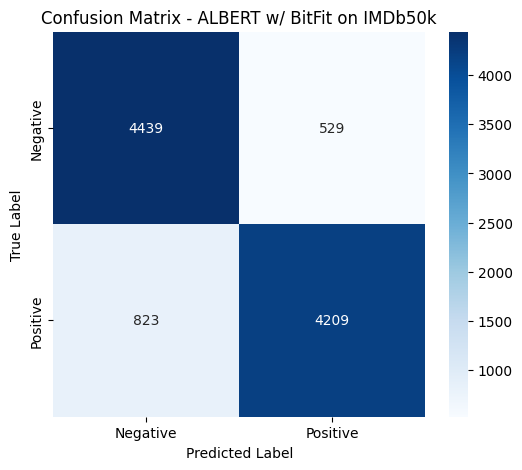

In [20]:
bf_best_lr = results[0]["learning_rate"]
bf_best_bs = results[0]["batch_size"]

# Construct filename
best_report_file = f"imdb_albert_bitfit_inference_metrics_summary_lr{bf_best_lr}_bs{bf_best_bs}.csv"

# Load the saved best report
best_report_df = pd.read_csv(best_report_file)
print("\nClassification Report for Best Configuration:")
print(best_report_df)


best_preds_df = pd.read_csv(f"imdb_albert_bitfit_inference_predictions_lr{bf_best_lr}_bs{bf_best_bs}.csv")
print("\nInference Predictions for Best Configuration:")
print(best_preds_df)

y_true = best_preds_df["y_true"]
y_pred = best_preds_df["y_pred"]


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ALBERT w/ BitFit on IMDb50k")
plt.show()

## Prompt Tuning

In [21]:
""" Importing prompt tuning packages from PEFT """

import gc
from peft import PromptTuningConfig, PromptTuningInit, get_peft_model, TaskType

In [22]:
""" Prompt tuning parameter setup """

lrs = [5e-5, 1e-4]
bs = [8, 16]
num_tokens = 20
epochs = 6

In [26]:
""" Training and evaluation loop with hyperparamter grid search """

from torch import autocast

results = []

for lr in lrs:
    for batch_size in bs:
        print(f"Running Prompt Tuning with LR={lr}, batch_size={batch_size}")

        # loading ALBERT model
        model_name = "albert-base-v2"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

        # prompt tuning config
        peft_config = PromptTuningConfig(
            task_type=TaskType.SEQ_CLS,
            num_virtual_tokens=num_tokens,
            tokenizer_name_or_path=tokenizer.name_or_path,
            prompt_tuning_init=PromptTuningInit.RANDOM,
        )
        prompt_model = get_peft_model(model, peft_config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        prompt_model.to(device)

        # instantiate dataloader
        data_collator = DataCollatorWithPadding(tokenizer)
        train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=batch_size, shuffle=True, collate_fn=data_collator)
        test_dataloader = DataLoader(tokenized_dataset["test"], batch_size=batch_size, shuffle=False, collate_fn=data_collator)

        # adam optimization
        optimizer = torch.optim.AdamW(prompt_model.parameters(), lr=lr)

        # begin training
        prompt_model.train()
        start_time = time.time()
        epoch_logs = []

        for epoch in range(1, epochs + 1):
            running_loss = 0.0
            correct = 0
            total = 0
            loop = tqdm(train_dataloader, leave=True, dynamic_ncols=True, desc=f"Epoch {epoch}/{epochs}")
            for step, batch in enumerate(loop):
                batch = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                    "labels": batch["labels"].to(device)
                }

                with autocast(device_type='cuda'):
                    outputs = model(**batch)
                    loss = outputs.loss
                    preds = torch.argmax(outputs.logits, dim=1)
                    correct += (preds == batch['labels']).sum().item()
                    total += batch['labels'].size(0)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()


            avg_train_loss = running_loss / (step + 1)
            train_accuracy = correct / total

            # perform per epoch evaluation
            prompt_model.eval()
            val_running_loss = 0.0
            y_true, y_pred = [], []
            with torch.no_grad():
                with autocast(device_type='cuda'):
                    for batch in test_dataloader:
                        batch = {
                            "input_ids": batch["input_ids"].to(device),
                            "attention_mask": batch["attention_mask"].to(device),
                            "labels": batch["labels"].to(device)
                        }
                        outputs = model(**batch)
                        preds = torch.argmax(outputs.logits, dim=1)
                        y_true.extend(batch["labels"].cpu().numpy())
                        y_pred.extend(preds.cpu().numpy())
                        val_running_loss += outputs.loss.item()

            avg_val_loss = val_running_loss / len(test_dataloader)

            inference_time = time.time() - start_time

            report = classification_report(y_true, y_pred, output_dict=True)
            val_accuracy = report["accuracy"]
            val_f1 = report["weighted avg"]["f1-score"]

            epoch_logs.append({
                "epoch": epoch,
                "lr": lr,
                "batch_size": batch_size,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy
            })

            if epoch == epochs:
                total_correct = sum(yt == yp for yt, yp in zip(y_true, y_pred))
                total_samples = len(y_true)
                accuracy = total_correct / total_samples
                f1_macro = f1_score(y_true, y_pred, average="macro")
                f1_weighted = f1_score(y_true, y_pred, average="weighted")

                print(f"\n[Final Epoch {epoch}] Inference Metrics:")
                print(f"Test Accuracy      : {accuracy:.4f}")
                print(f"F1 Score (macro)   : {f1_macro:.4f}")
                print(f"F1 Score (weighted): {f1_weighted:.4f}")
                print(f"Inference Time     : {inference_time:.2f} seconds")
                print("\nClassification Report: ALBERT w/ Prompt Tuning on IMDb50k\n")
                print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

            prompt_model.train()

        end_time = time.time()
        training_time = end_time - start_time

        # begin datalogging per lr/bs
        epoch_logs_df = pd.DataFrame(epoch_logs)
        epoch_logs_df.to_csv(f"imdb_albert_prompt_epoch_logs_lr{lr}_bs{batch_size}.csv", index=False)

        # save inference metrics per lr/bs
        metrics_summary_df = pd.DataFrame(report).transpose()
        metrics_summary_df.to_csv(f"imdb_albert_prompt_inference_metrics_summary_lr{lr}_bs{batch_size}.csv", index=True)

        # Save inference predictions for the final epoch
        predictions_df = pd.DataFrame({
            "y_true": y_true,
            "y_pred": y_pred
        })
        predictions_df.to_csv(f"imdb_albert_prompt_inference_predictions_lr{lr}_bs{batch_size}.csv", index=False)

        # log memory usage
        max_memory = torch.cuda.max_memory_allocated() / (1024 ** 3) if torch.cuda.is_available() else 0

        # save model params and metrics
        results.append({
            "method": "Prompt Tuning",
            "learning_rate": lr,
            "batch_size": batch_size,
            "accuracy": val_accuracy,
            "f1": val_f1,
            "training_time": training_time,
            "inference_time": inference_time,
            "max_memory": max_memory
        })

        # empty cache to conserve compute
        del prompt_model, model, tokenizer, optimizer
        torch.cuda.empty_cache()
        gc.collect()

# ranked performance by val acc
results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

# save overall results
results_df = pd.DataFrame(results)
results_df.to_csv("imdb_albert_prompt_results.csv", index=False)

# save best final config and metrics
final_summary_df = pd.DataFrame({
    "Method": ["Prompt Tuning"],
    "Best LR": [results[0]["learning_rate"]],
    "Best Batch Size": [results[0]["batch_size"]],
    "Accuracy": [results[0]["accuracy"]],
    "F1 Score": [results[0]["f1"]],
    "Training Time (s)": [results[0]["training_time"]],
    "Max GPU Memory (GB)": [results[0]["max_memory"]]
})
final_summary_df.to_csv("imdb_albert_prompt_final_comparison_prompt_tuning.csv", index=False)

print("All Prompt Tuning Grid Search Results:")
for r in results:
    print(r)

print("\nBest Configuration:")
print(results[0])

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running Prompt Tuning with LR=5e-05, batch_size=8


Epoch 6/6: 100%|██████████| 5000/5000 [01:30<00:00, 55.51it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.7256
F1 Score (macro)   : 0.7256
F1 Score (weighted): 0.7256
Inference Time     : 659.82 seconds

Classification Report: ALBERT w/ Prompt Tuning on IMDb50k

              precision    recall  f1-score   support

    Negative       0.73      0.72      0.72      4968
    Positive       0.73      0.73      0.73      5032

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000

Running Prompt Tuning with LR=5e-05, batch_size=16


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 6/6: 100%|██████████| 2500/2500 [00:50<00:00, 49.49it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.7163
F1 Score (macro)   : 0.7162
F1 Score (weighted): 0.7162
Inference Time     : 371.77 seconds

Classification Report: ALBERT w/ Prompt Tuning on IMDb50k

              precision    recall  f1-score   support

    Negative       0.71      0.73      0.72      4968
    Positive       0.73      0.70      0.71      5032

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000

Running Prompt Tuning with LR=0.0001, batch_size=8


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 6/6: 100%|██████████| 5000/5000 [01:30<00:00, 55.11it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.7358
F1 Score (macro)   : 0.7358
F1 Score (weighted): 0.7358
Inference Time     : 668.64 seconds

Classification Report: ALBERT w/ Prompt Tuning on IMDb50k

              precision    recall  f1-score   support

    Negative       0.73      0.75      0.74      4968
    Positive       0.74      0.73      0.73      5032

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

Running Prompt Tuning with LR=0.0001, batch_size=16


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 6/6: 100%|██████████| 2500/2500 [00:51<00:00, 48.18it/s]



[Final Epoch 6] Inference Metrics:
Test Accuracy      : 0.7229
F1 Score (macro)   : 0.7213
F1 Score (weighted): 0.7212
Inference Time     : 380.87 seconds

Classification Report: ALBERT w/ Prompt Tuning on IMDb50k

              precision    recall  f1-score   support

    Negative       0.69      0.80      0.74      4968
    Positive       0.77      0.64      0.70      5032

    accuracy                           0.72     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.73      0.72      0.72     10000

All Prompt Tuning Grid Search Results:
{'method': 'Prompt Tuning', 'learning_rate': 0.0001, 'batch_size': 8, 'accuracy': 0.7358, 'f1': 0.7357840630250642, 'training_time': 668.6969864368439, 'inference_time': 668.6412310600281, 'max_memory': 2.270575523376465}
{'method': 'Prompt Tuning', 'learning_rate': 5e-05, 'batch_size': 8, 'accuracy': 0.7256, 'f1': 0.7255922612362028, 'training_time': 659.8711113929749, 'inference_time': 659.8161127567291, 'max_mem


Classification Report for Best Configuration:
     Unnamed: 0  precision    recall  f1-score     support
0             0   0.728757  0.745773  0.737167   4968.0000
1             1   0.743084  0.725954  0.734419   5032.0000
2      accuracy   0.735800  0.735800  0.735800      0.7358
3     macro avg   0.735920  0.735863  0.735793  10000.0000
4  weighted avg   0.735966  0.735800  0.735784  10000.0000

Inference Predictions for Best Configuration:
      y_true  y_pred
0          0       0
1          1       0
2          1       1
3          0       0
4          1       1
...      ...     ...
9995       1       1
9996       1       1
9997       1       1
9998       1       1
9999       1       0

[10000 rows x 2 columns]


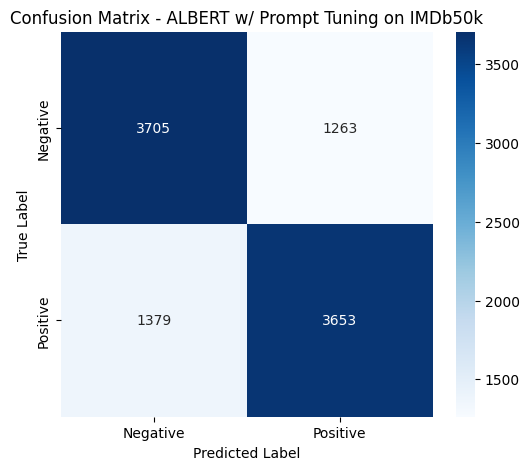

In [27]:
prompt_best_lr = results[0]["learning_rate"]
prompt_best_bs = results[0]["batch_size"]

# Construct filename
best_report_file = f"imdb_albert_prompt_inference_metrics_summary_lr{prompt_best_lr}_bs{prompt_best_bs}.csv"

# Load the saved best report
best_report_df = pd.read_csv(best_report_file)
print("\nClassification Report for Best Configuration:")
print(best_report_df)


best_preds_df = pd.read_csv(f"imdb_albert_prompt_inference_predictions_lr{prompt_best_lr}_bs{prompt_best_bs}.csv")
print("\nInference Predictions for Best Configuration:")
print(best_preds_df)

y_true = best_preds_df["y_true"]
y_pred = best_preds_df["y_pred"]


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ALBERT w/ Prompt Tuning on IMDb50k")
plt.show()

##Begin Visualization of IMDb 50k Results

Load all dataframes from above training of 3 PEFT methods

In [30]:
""" Output from our ALBERT_Sentiment140_IMDb50k.ipynb file, we read in the .csv files here.
Note that these .csv file paths suggest they should be uploaded to session storage"""

# ALBERT PEFT-wise results across bf/lora/prompt tuning
albert_bf_results = pd.read_csv('/content/imdb_albert_bitfit_results.csv')
albert_lora_results = pd.read_csv('/content/imdb_albert_lora_results.csv')
albert_prompt_results = pd.read_csv('/content/imdb_albert_prompt_results.csv')

# ALBERT per-epoch performance logs (for LC generation) across bf/lora/prompt tuning
albert_lora_epochs_lr5_bs8 = pd.read_csv('/content/imdb_albert_lora_epoch_logs_lr5e-05_bs8.csv')
albert_lora_epochs_lr5_bs16 = pd.read_csv('/content/imdb_albert_lora_epoch_logs_lr5e-05_bs16.csv')
albert_lora_epochs_lr1_bs8 = pd.read_csv('/content/imdb_albert_lora_epoch_logs_lr0.0001_bs8.csv')
albert_lora_epochs_lr1_bs16 = pd.read_csv('/content/imdb_albert_lora_epoch_logs_lr0.0001_bs16.csv')
albert_bf_epochs_lr5_bs8 = pd.read_csv('/content/imdb_albert_bitfit_epoch_logs_lr5e-05_bs8.csv')
albert_bf_epochs_lr5_bs16 = pd.read_csv('/content/imdb_albert_bitfit_epoch_logs_lr5e-05_bs16.csv')
albert_bf_epochs_lr1_bs8 = pd.read_csv('/content/imdb_albert_bitfit_epoch_logs_lr0.0001_bs8.csv')
albert_bf_epochs_lr1_bs16 = pd.read_csv('/content/imdb_albert_bitfit_epoch_logs_lr0.0001_bs16.csv')
albert_prompt_epochs_lr5_bs8 = pd.read_csv('/content/imdb_albert_prompt_epoch_logs_lr5e-05_bs8.csv')
albert_prompt_epochs_lr5_bs16 = pd.read_csv('/content/imdb_albert_prompt_epoch_logs_lr5e-05_bs16.csv')
albert_prompt_epochs_lr1_bs8 = pd.read_csv('/content/imdb_albert_prompt_epoch_logs_lr0.0001_bs8.csv')
albert_prompt_epochs_lr1_bs16 = pd.read_csv('/content/imdb_albert_prompt_epoch_logs_lr0.0001_bs16.csv')

# ALBERT inference performance metric summary across bf/lora/prompt tuning
albert_bf_inf_lr5_bs8 = pd.read_csv('/content/imdb_albert_bitfit_inference_metrics_summary_lr5e-05_bs8.csv')
albert_bf_inf_lr5_bs16 = pd.read_csv('/content/imdb_albert_bitfit_inference_metrics_summary_lr5e-05_bs16.csv')
albert_bf_inf_lr1_bs8 = pd.read_csv('/content/imdb_albert_bitfit_inference_metrics_summary_lr0.0001_bs8.csv')
albert_bf_inf_lr1_bs16 = pd.read_csv('/content/imdb_albert_bitfit_inference_metrics_summary_lr0.0001_bs16.csv')
albert_lora_inf_lr5_bs8 = pd.read_csv('/content/imdb_albert_lora_inference_metrics_summary_lr5e-05_bs8.csv')
albert_lora_inf_lr5_bs16 = pd.read_csv('/content/imdb_albert_lora_inference_metrics_summary_lr5e-05_bs16.csv')
albert_lora_inf_lr1_bs8 = pd.read_csv('/content/imdb_albert_lora_inference_metrics_summary_lr0.0001_bs8.csv')
albert_lora_inf_lr1_bs16 = pd.read_csv('/content/imdb_albert_lora_inference_metrics_summary_lr0.0001_bs16.csv')
albert_prompt_inf_lr5_bs8 = pd.read_csv('/content/imdb_albert_prompt_inference_metrics_summary_lr5e-05_bs8.csv')
albert_prompt_inf_lr5_bs16 = pd.read_csv('/content/imdb_albert_prompt_inference_metrics_summary_lr5e-05_bs16.csv')
albert_prompt_inf_lr1_bs8 = pd.read_csv('/content/imdb_albert_prompt_inference_metrics_summary_lr0.0001_bs8.csv')
albert_prompt_inf_lr1_bs16 = pd.read_csv('/content/imdb_albert_prompt_inference_metrics_summary_lr0.0001_bs16.csv')

# ALBERT inference predictions across bf/lora/prompt tuning
albert_bf_preds_lr5_bs8 = pd.read_csv('/content/imdb_albert_bitfit_inference_predictions_lr5e-05_bs8.csv')
albert_bf_preds_lr5_bs16 = pd.read_csv('/content/imdb_albert_bitfit_inference_predictions_lr5e-05_bs16.csv')
albert_bf_preds_lr1_bs8 = pd.read_csv('/content/imdb_albert_bitfit_inference_predictions_lr0.0001_bs8.csv')
albert_bf_preds_lr1_bs16 = pd.read_csv('/content/imdb_albert_bitfit_inference_predictions_lr0.0001_bs16.csv')
albert_lora_preds_lr5_bs8 = pd.read_csv('/content/imdb_albert_lora_inference_predictions_lr5e-05_bs8.csv')
albert_lora_preds_lr5_bs16 = pd.read_csv('/content/imdb_albert_lora_inference_predictions_lr5e-05_bs16.csv')
albert_lora_preds_lr1_bs8 = pd.read_csv('/content/imdb_albert_lora_inference_predictions_lr0.0001_bs8.csv')
albert_lora_preds_lr1_bs16 = pd.read_csv('/content/imdb_albert_lora_inference_predictions_lr0.0001_bs16.csv')
albert_prompt_preds_lr5_bs8 = pd.read_csv('/content/imdb_albert_prompt_inference_predictions_lr5e-05_bs8.csv')
albert_prompt_preds_lr5_bs16 = pd.read_csv('/content/imdb_albert_prompt_inference_predictions_lr5e-05_bs16.csv')
albert_prompt_preds_lr1_bs8 = pd.read_csv('/content/imdb_albert_prompt_inference_predictions_lr0.0001_bs8.csv')
albert_prompt_preds_lr1_bs16 = pd.read_csv('/content/imdb_albert_prompt_inference_predictions_lr0.0001_bs16.csv')

# ALBERT PEFT method intra-comparison based on hyperparameter settings, per bf/lora/prompt tuning
albert_bf_final_comparison = pd.read_csv('/content/imdb_albert_bf_final_comparison_bitfit.csv')
albert_lora_final_comparison = pd.read_csv('/content/imdb_albert_lora_final_comparison_lora.csv')
albert_prompt_final_comparison = pd.read_csv('/content/imdb_albert_prompt_final_comparison_prompt_tuning.csv')


BitFit Learning Curves

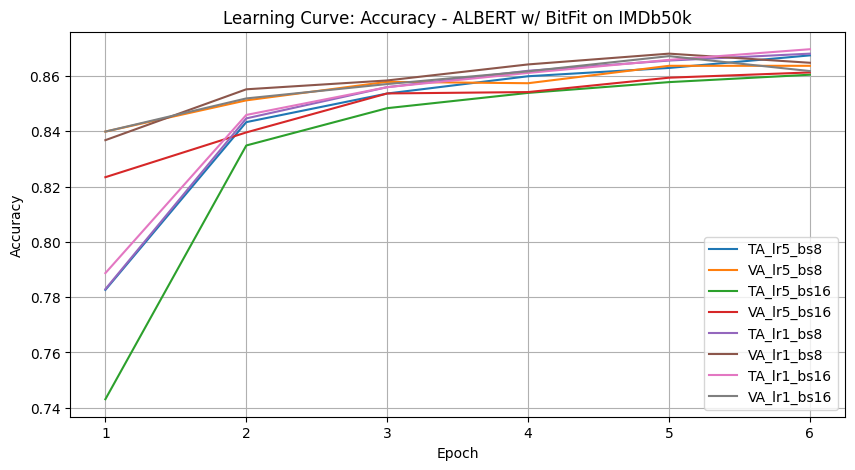

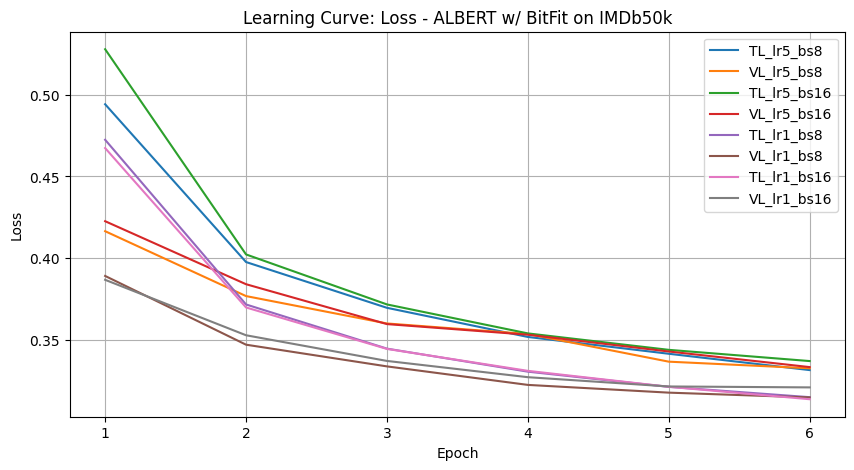

In [31]:
# All BitFit Train/Val Acc Learning Curve
plt.figure(figsize=(10,5))
sns.lineplot(data=albert_bf_epochs_lr5_bs8, x="epoch", y="train_accuracy", label="TA_lr5_bs8")
sns.lineplot(data=albert_bf_epochs_lr5_bs8, x="epoch", y="val_accuracy", label="VA_lr5_bs8")
sns.lineplot(data=albert_bf_epochs_lr5_bs16, x="epoch", y="train_accuracy", label="TA_lr5_bs16")
sns.lineplot(data=albert_bf_epochs_lr5_bs16, x="epoch", y="val_accuracy", label="VA_lr5_bs16")
sns.lineplot(data=albert_bf_epochs_lr1_bs8, x="epoch", y="train_accuracy", label="TA_lr1_bs8")
sns.lineplot(data=albert_bf_epochs_lr1_bs8, x="epoch", y="val_accuracy", label="VA_lr1_bs8")
sns.lineplot(data=albert_bf_epochs_lr1_bs16, x="epoch", y="train_accuracy", label="TA_lr1_bs16")
sns.lineplot(data=albert_bf_epochs_lr1_bs16, x="epoch", y="val_accuracy", label="VA_lr1_bs16")
plt.title("Learning Curve: Accuracy - ALBERT w/ BitFit on IMDb50k")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# All BitFit Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=albert_bf_epochs_lr5_bs8, x="epoch", y="train_loss", label="TL_lr5_bs8")
sns.lineplot(data=albert_bf_epochs_lr5_bs8, x="epoch", y="val_loss", label="VL_lr5_bs8")
sns.lineplot(data=albert_bf_epochs_lr5_bs16, x="epoch", y="train_loss", label="TL_lr5_bs16")
sns.lineplot(data=albert_bf_epochs_lr5_bs16, x="epoch", y="val_loss", label="VL_lr5_bs16")
sns.lineplot(data=albert_bf_epochs_lr1_bs8, x="epoch", y="train_loss", label="TL_lr1_bs8")
sns.lineplot(data=albert_bf_epochs_lr1_bs8, x="epoch", y="val_loss", label="VL_lr1_bs8")
sns.lineplot(data=albert_bf_epochs_lr1_bs16, x="epoch", y="train_loss", label="TL_lr1_bs16")
sns.lineplot(data=albert_bf_epochs_lr1_bs16, x="epoch", y="val_loss", label="VL_lr1_bs16")
plt.title("Learning Curve: Loss - ALBERT w/ BitFit on IMDb50k")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


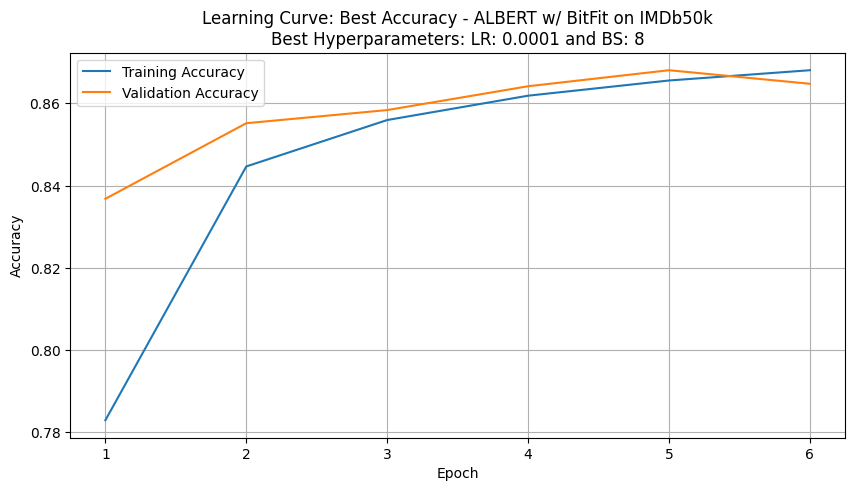

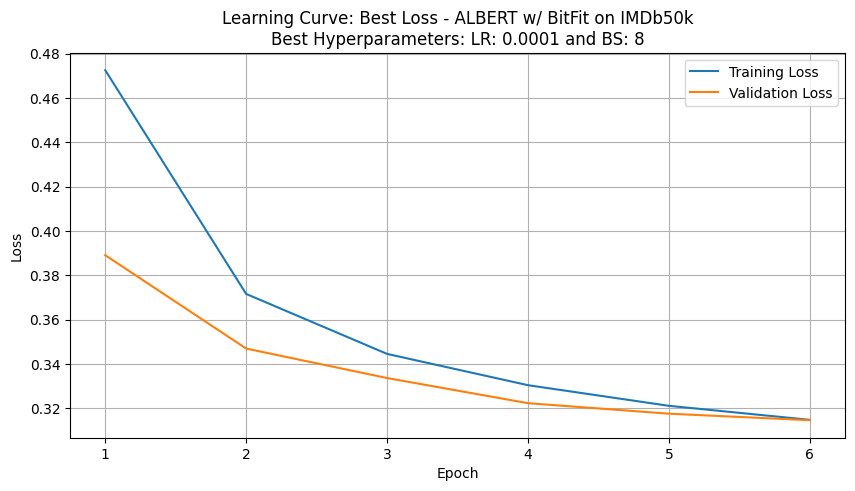

In [32]:
# Best BitFit Train/Val Acc Learning Curve

albert_bf_epochs_map = {
    (5, 8): albert_bf_epochs_lr5_bs8,
    (5, 16): albert_bf_epochs_lr5_bs16,
    (1, 8): albert_bf_epochs_lr1_bs8,
    (1, 16): albert_bf_epochs_lr1_bs16
}

bf_lr_mapping = {
    5e-5: 5,
    1e-4: 1
}

bf_best_lr_tag = bf_lr_mapping[bf_best_lr]
bf_best_bs_tag = bf_best_bs

bf_epochs = albert_bf_epochs_map[(bf_best_lr_tag, bf_best_bs_tag)]

# Best BitFit Training and Validation Accuracy
plt.figure(figsize=(10,5))
sns.lineplot(data=bf_epochs, x="epoch", y="train_accuracy", label="Training Accuracy")
sns.lineplot(data=bf_epochs, x="epoch", y="val_accuracy", label="Validation Accuracy")
plt.title(f"Learning Curve: Best Accuracy - ALBERT w/ BitFit on IMDb50k\nBest Hyperparameters: LR: {bf_best_lr} and BS: {bf_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Best BitFit Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=bf_epochs, x="epoch", y="train_loss", label="Training Loss")
sns.lineplot(data=bf_epochs, x="epoch", y="val_loss", label="Validation Loss")
plt.title(f"Learning Curve: Best Loss - ALBERT w/ BitFit on IMDb50k\nBest Hyperparameters: LR: {bf_best_lr} and BS: {bf_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

LoRA Learning Curves

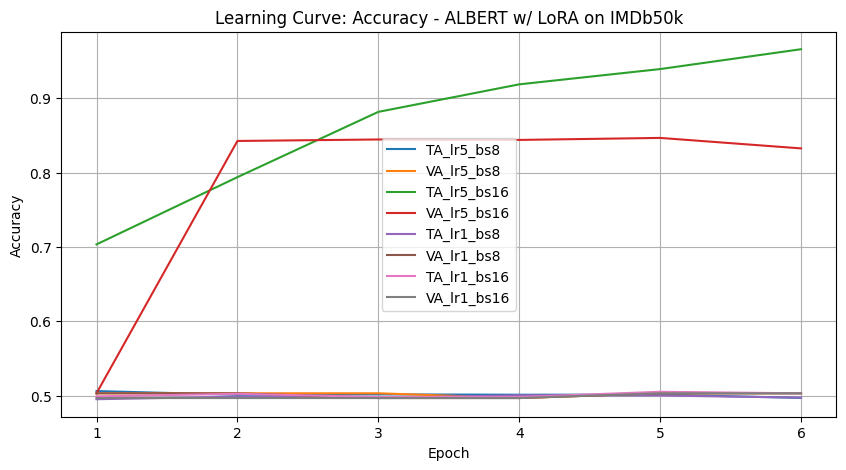

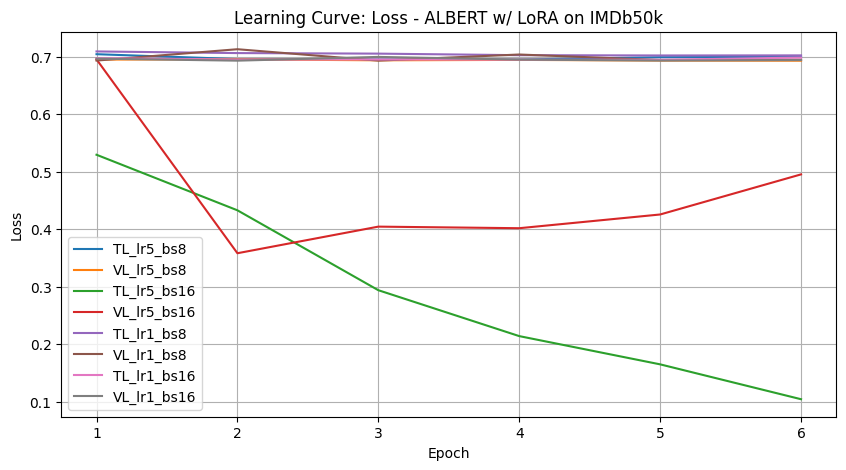

In [33]:
# All LoRA Train/Val Acc Learning Curve (ALBERT)
plt.figure(figsize=(10,5))
sns.lineplot(data=albert_lora_epochs_lr5_bs8, x="epoch", y="train_accuracy", label="TA_lr5_bs8")
sns.lineplot(data=albert_lora_epochs_lr5_bs8, x="epoch", y="val_accuracy", label="VA_lr5_bs8")
sns.lineplot(data=albert_lora_epochs_lr5_bs16, x="epoch", y="train_accuracy", label="TA_lr5_bs16")
sns.lineplot(data=albert_lora_epochs_lr5_bs16, x="epoch", y="val_accuracy", label="VA_lr5_bs16")
sns.lineplot(data=albert_lora_epochs_lr1_bs8, x="epoch", y="train_accuracy", label="TA_lr1_bs8")
sns.lineplot(data=albert_lora_epochs_lr1_bs8, x="epoch", y="val_accuracy", label="VA_lr1_bs8")
sns.lineplot(data=albert_lora_epochs_lr1_bs16, x="epoch", y="train_accuracy", label="TA_lr1_bs16")
sns.lineplot(data=albert_lora_epochs_lr1_bs16, x="epoch", y="val_accuracy", label="VA_lr1_bs16")
plt.title("Learning Curve: Accuracy - ALBERT w/ LoRA on IMDb50k")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# All LoRA Training and Validation Loss (ALBERT)
plt.figure(figsize=(10,5))
sns.lineplot(data=albert_lora_epochs_lr5_bs8, x="epoch", y="train_loss", label="TL_lr5_bs8")
sns.lineplot(data=albert_lora_epochs_lr5_bs8, x="epoch", y="val_loss", label="VL_lr5_bs8")
sns.lineplot(data=albert_lora_epochs_lr5_bs16, x="epoch", y="train_loss", label="TL_lr5_bs16")
sns.lineplot(data=albert_lora_epochs_lr5_bs16, x="epoch", y="val_loss", label="VL_lr5_bs16")
sns.lineplot(data=albert_lora_epochs_lr1_bs8, x="epoch", y="train_loss", label="TL_lr1_bs8")
sns.lineplot(data=albert_lora_epochs_lr1_bs8, x="epoch", y="val_loss", label="VL_lr1_bs8")
sns.lineplot(data=albert_lora_epochs_lr1_bs16, x="epoch", y="train_loss", label="TL_lr1_bs16")
sns.lineplot(data=albert_lora_epochs_lr1_bs16, x="epoch", y="val_loss", label="VL_lr1_bs16")
plt.title("Learning Curve: Loss - ALBERT w/ LoRA on IMDb50k")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


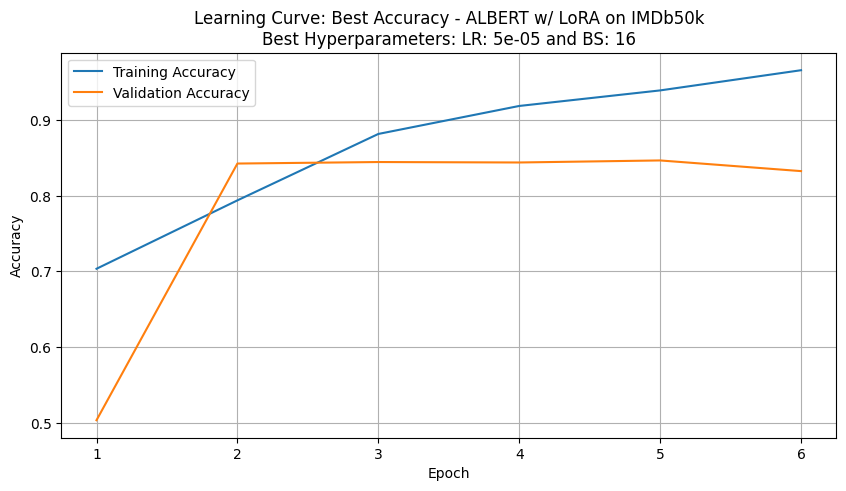

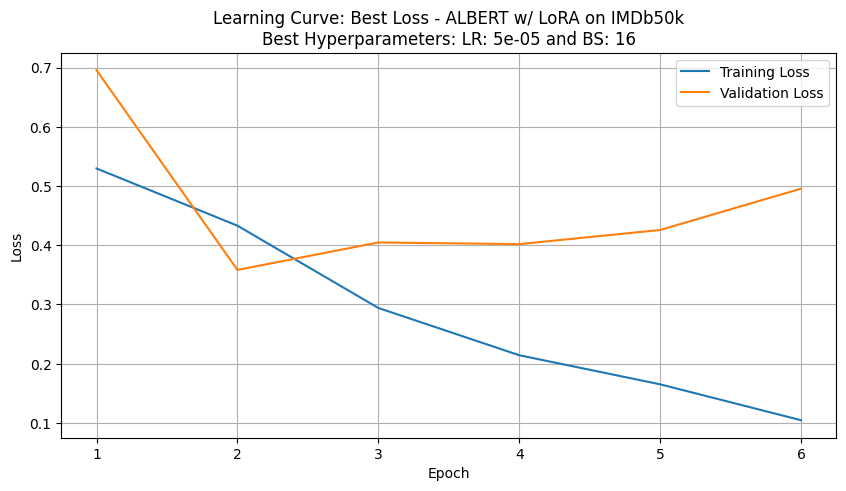

In [34]:
# Best LoRA Train/Val Acc Learning Curve

albert_lora_epochs_map = {
    (5, 8): albert_lora_epochs_lr5_bs8,
    (5, 16): albert_lora_epochs_lr5_bs16,
    (1, 8): albert_lora_epochs_lr1_bs8,
    (1, 16): albert_lora_epochs_lr1_bs16
}

lora_lr_mapping = {
    5e-5: 5,
    1e-4: 1
}

lora_best_lr_tag = lora_lr_mapping[lora_best_lr]
lora_best_bs_tag = lora_best_bs

lora_epochs = albert_lora_epochs_map[(lora_best_lr_tag, lora_best_bs_tag)]

# Best LoRA Training and Validation Accuracy
plt.figure(figsize=(10,5))
sns.lineplot(data=lora_epochs, x="epoch", y="train_accuracy", label="Training Accuracy")
sns.lineplot(data=lora_epochs, x="epoch", y="val_accuracy", label="Validation Accuracy")
plt.title(f"Learning Curve: Best Accuracy - ALBERT w/ LoRA on IMDb50k\nBest Hyperparameters: LR: {lora_best_lr} and BS: {lora_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Best LoRA Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=lora_epochs, x="epoch", y="train_loss", label="Training Loss")
sns.lineplot(data=lora_epochs, x="epoch", y="val_loss", label="Validation Loss")
plt.title(f"Learning Curve: Best Loss - ALBERT w/ LoRA on IMDb50k\nBest Hyperparameters: LR: {lora_best_lr} and BS: {lora_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

Prompt Tuning Learning Curves

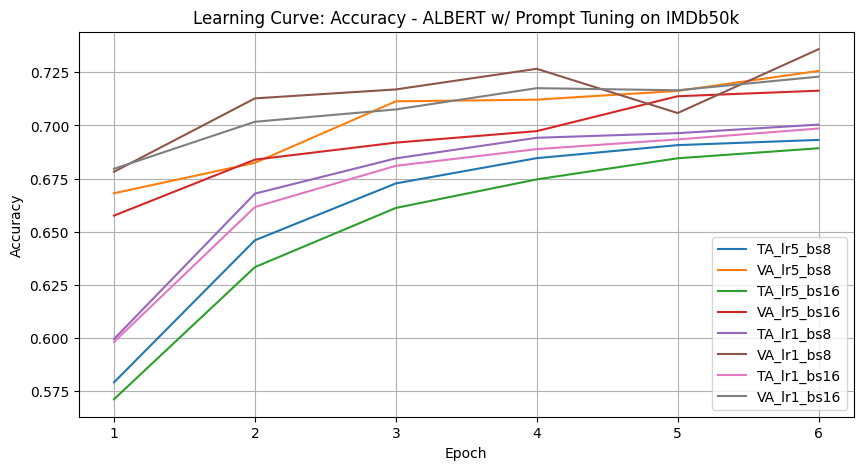

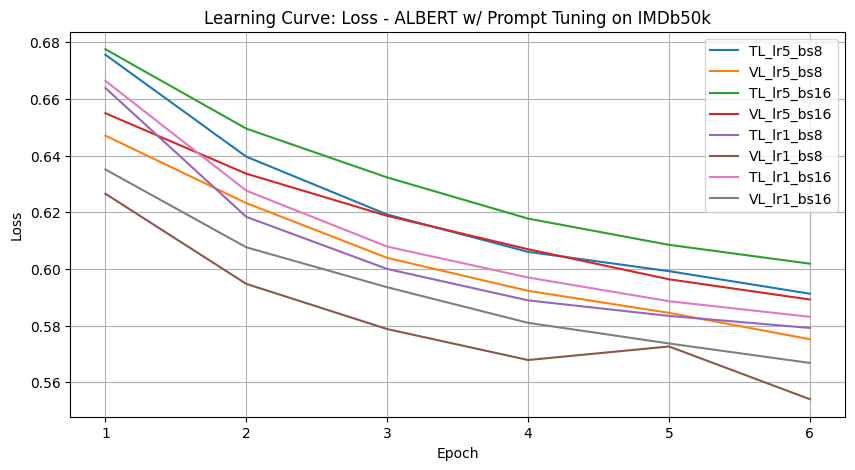

In [35]:
# All Prompt Tuning Train/Val Acc Learning Curve
plt.figure(figsize=(10,5))
sns.lineplot(data=albert_prompt_epochs_lr5_bs8, x="epoch", y="train_accuracy", label="TA_lr5_bs8")
sns.lineplot(data=albert_prompt_epochs_lr5_bs8, x="epoch", y="val_accuracy", label="VA_lr5_bs8")
sns.lineplot(data=albert_prompt_epochs_lr5_bs16, x="epoch", y="train_accuracy", label="TA_lr5_bs16")
sns.lineplot(data=albert_prompt_epochs_lr5_bs16, x="epoch", y="val_accuracy", label="VA_lr5_bs16")
sns.lineplot(data=albert_prompt_epochs_lr1_bs8, x="epoch", y="train_accuracy", label="TA_lr1_bs8")
sns.lineplot(data=albert_prompt_epochs_lr1_bs8, x="epoch", y="val_accuracy", label="VA_lr1_bs8")
sns.lineplot(data=albert_prompt_epochs_lr1_bs16, x="epoch", y="train_accuracy", label="TA_lr1_bs16")
sns.lineplot(data=albert_prompt_epochs_lr1_bs16, x="epoch", y="val_accuracy", label="VA_lr1_bs16")
plt.title("Learning Curve: Accuracy - ALBERT w/ Prompt Tuning on IMDb50k")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# All Prompt Tuning Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=albert_prompt_epochs_lr5_bs8, x="epoch", y="train_loss", label="TL_lr5_bs8")
sns.lineplot(data=albert_prompt_epochs_lr5_bs8, x="epoch", y="val_loss", label="VL_lr5_bs8")
sns.lineplot(data=albert_prompt_epochs_lr5_bs16, x="epoch", y="train_loss", label="TL_lr5_bs16")
sns.lineplot(data=albert_prompt_epochs_lr5_bs16, x="epoch", y="val_loss", label="VL_lr5_bs16")
sns.lineplot(data=albert_prompt_epochs_lr1_bs8, x="epoch", y="train_loss", label="TL_lr1_bs8")
sns.lineplot(data=albert_prompt_epochs_lr1_bs8, x="epoch", y="val_loss", label="VL_lr1_bs8")
sns.lineplot(data=albert_prompt_epochs_lr1_bs16, x="epoch", y="train_loss", label="TL_lr1_bs16")
sns.lineplot(data=albert_prompt_epochs_lr1_bs16, x="epoch", y="val_loss", label="VL_lr1_bs16")
plt.title("Learning Curve: Loss - ALBERT w/ Prompt Tuning on IMDb50k")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

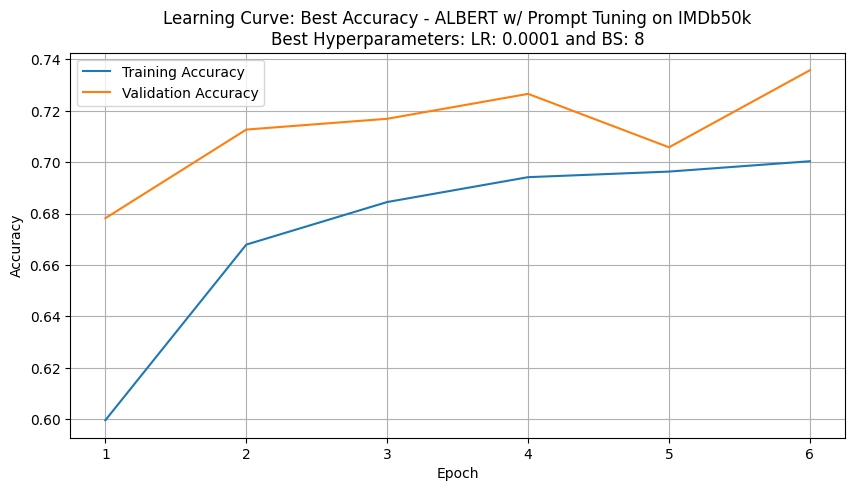

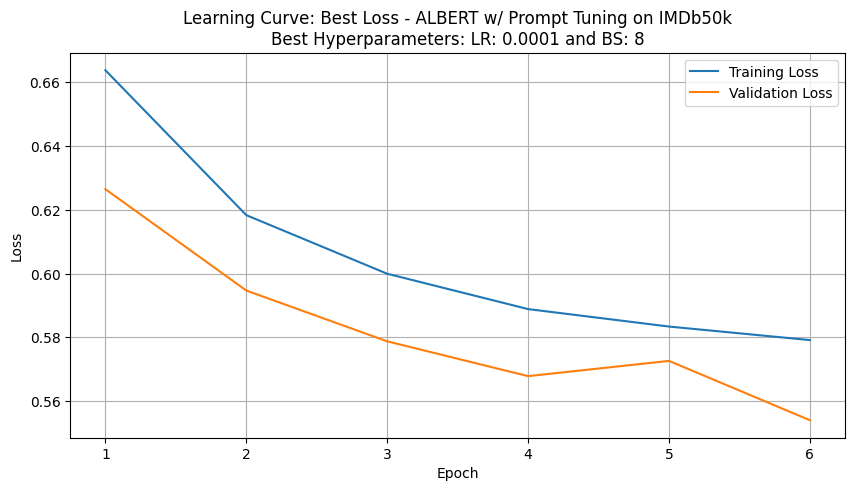

In [45]:
# Best Prompt Tuning Train/Val Acc Learning Curve

albert_prompt_epochs_map = {
    (5, 8): albert_prompt_epochs_lr5_bs8,
    (5, 16): albert_prompt_epochs_lr5_bs16,
    (1, 8): albert_prompt_epochs_lr1_bs8,
    (1, 16): albert_prompt_epochs_lr1_bs16
}

prompt_lr_mapping = {
    5e-5: "5e-5",
    1e-4: "41e-"
}

prompt_best_lr_tag_for_map = {5e-5: 5, 1e-4: 1}[prompt_best_lr]

prompt_best_bs_tag = prompt_best_bs

prompt_epochs = albert_prompt_epochs_map[(prompt_best_lr_tag_for_map, prompt_best_bs_tag)]

# Best Prompt Tuning Training and Validation Accuracy
plt.figure(figsize=(10,5))
sns.lineplot(data=prompt_epochs, x="epoch", y="train_accuracy", label="Training Accuracy")
sns.lineplot(data=prompt_epochs, x="epoch", y="val_accuracy", label="Validation Accuracy")
plt.title(f"Learning Curve: Best Accuracy - ALBERT w/ Prompt Tuning on IMDb50k\nBest Hyperparameters: LR: {prompt_best_lr} and BS: {prompt_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Best Prompt Tuning Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=prompt_epochs, x="epoch", y="train_loss", label="Training Loss")
sns.lineplot(data=prompt_epochs, x="epoch", y="val_loss", label="Validation Loss")
plt.title(f"Learning Curve: Best Loss - ALBERT w/ Prompt Tuning on IMDb50k\nBest Hyperparameters: LR: {prompt_best_lr} and BS: {prompt_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

PEFT Method Comparison:

In [46]:
# Final results per BitFit/LoRA/Prompt Tuning Implementation

albert_bf_results = pd.read_csv('/content/imdb_albert_bitfit_results.csv')
albert_lora_results = pd.read_csv('/content/imdb_albert_lora_results.csv')
albert_prompt_results = pd.read_csv('/content/imdb_albert_prompt_results.csv')

# Table of comparisons
comparison = pd.DataFrame({
    "Method": ["BitFit", "LoRA", "Prompt Tuning"],
    "Best Validation F1": [
        albert_bf_results["f1"].max(),
        albert_lora_results["f1"].max(),
        albert_prompt_results["f1"].max()
    ],
    "Best Validation Accuracy": [
        albert_bf_results["accuracy"].max(),
        albert_lora_results["accuracy"].max(),
        albert_prompt_results["accuracy"].max()
    ],
    "Runtime (sec)": [
        albert_bf_results["training_time"].sum(),
        albert_lora_results["training_time"].sum(),
        albert_prompt_results["training_time"].sum()
    ],
    "Inference Time (sec)": [
        albert_bf_results["inference_time"].sum(),
        albert_lora_results["inference_time"].sum(),
        albert_prompt_results["inference_time"].sum()
    ],
    "Max GPU Memory (GB)": [
        albert_bf_results["max_memory"].max(),
        albert_lora_results["max_memory"].max(),
        albert_prompt_results["max_memory"].max()
    ]
})

print("\nFinal Validation Performance PEFT Comparison - ALBERT on IMDb50k:")
display(comparison)



Final Validation Performance PEFT Comparison - ALBERT on IMDb50k:


,Method,Best Validation F1,Best Validation Accuracy,Runtime (sec),Inference Time (sec),Max GPU Memory (GB)
0,BitFit,0.864709,0.8648,4736.257788,86.522556,2.270576
1,LoRA,0.832361,0.8324,6141.177546,86.203370,2.270576
2,Prompt Tuning,0.735784,0.7358,2081.322940,2081.095943,2.270576


In [47]:
# Load overall results where inference_time is stored
albert_prompt_results = pd.read_csv('/content/imdb_albert_prompt_results.csv')
albert_bf_results = pd.read_csv('/content/imdb_albert_bitfit_results.csv')
albert_lora_results = pd.read_csv('/content/imdb_albert_lora_results.csv')

# Manually map best learning rates to filename tags (from before)
lr_tag_mapping = {
    5e-5: "5e-05",
    1e-4: "0.0001"
}
bf_best_lr_tag = lr_tag_mapping[bf_best_lr]
lora_best_lr_tag = lr_tag_mapping[lora_best_lr]
prompt_best_lr_tag = lr_tag_mapping[prompt_best_lr]

# Load best inference metric summaries
bf_inf = pd.read_csv(f'/content/imdb_albert_bitfit_inference_metrics_summary_lr{bf_best_lr_tag}_bs{bf_best_bs}.csv', index_col=0)
lora_inf = pd.read_csv(f'/content/imdb_albert_lora_inference_metrics_summary_lr{lora_best_lr_tag}_bs{lora_best_bs}.csv', index_col=0)
prompt_inf = pd.read_csv(f'/content/imdb_albert_prompt_inference_metrics_summary_lr{prompt_best_lr_tag}_bs{prompt_best_bs}.csv', index_col=0)

# Extract inference times
bf_inference_time = albert_bf_results[
    (albert_bf_results["learning_rate"] == bf_best_lr) &
    (albert_bf_results["batch_size"] == bf_best_bs)
]["inference_time"].values[0]

lora_inference_time = albert_lora_results[
    (albert_bf_results["learning_rate"] == lora_best_lr) &
    (albert_lora_results["batch_size"] == lora_best_bs)
]["inference_time"].values[0]

prompt_inference_time = albert_prompt_results[
    (albert_prompt_results["learning_rate"] == prompt_best_lr) &
    (albert_prompt_results["batch_size"] == prompt_best_bs)
]["inference_time"].values[0]

# Table of best per-implementation metrics (based on best lr and bs per PEFT method)
final_test_results = pd.DataFrame({
    "Method": ["BitFit", "LoRA", "Prompt Tuning"],
    "Test Accuracy": [
        bf_inf.loc["accuracy", "precision"],
        lora_inf.loc["accuracy", "precision"],
        prompt_inf.loc["accuracy", "precision"]
    ],
    "F1 Macro": [
        bf_inf.loc["macro avg", "f1-score"],
        lora_inf.loc["macro avg", "f1-score"],
        prompt_inf.loc["macro avg", "f1-score"]
    ],
    "F1 Weighted": [
        bf_inf.loc["weighted avg", "f1-score"],
        lora_inf.loc["weighted avg", "f1-score"],
        prompt_inf.loc["weighted avg", "f1-score"]
    ],
    "Inference Time (sec)": [
        bf_inference_time,
        lora_inference_time,
        prompt_inference_time
    ]
})

print("\nFinal Test Set Inference Performance PEFT Comparison - ALBERT on IMDb50k:")
display(final_test_results)


Final Test Set Inference Performance PEFT Comparison - ALBERT on IMDb50k:


,Method,Test Accuracy,F1 Macro,F1 Weighted,Inference Time (sec)
0,BitFit,0.8648,0.864728,0.864709,21.858219
1,LoRA,0.8324,0.832341,0.832361,21.190696
2,Prompt Tuning,0.7358,0.735793,0.735784,668.641231


In [ ]:
# Zip the entire /content folder
!zip -r /content/ALBERT_IMDb_solo.zip /content

# Download the zipped file
from google.colab import files
files.download('/content/ALBERT_IMDb_solo.zip')